In [1]:
########### import Packages ###########################
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import scipy.io as sio
import random
# import h5py
from keras import backend
from keras.models import Model
from sklearn.metrics import mean_squared_error

%matplotlib inline

Using TensorFlow backend.


In [2]:
########################## Weight initializer #######################
def he_normal_conv(size):
    in_dim = size[2] #input dimension
    he_stddev = tf.sqrt(2./in_dim)
    return tf.random_normal(shape=size, stddev=he_stddev, dtype=tf.float32)

def he_normal_fc(size):
    in_dim = size[0] #input dimension
    he_stddev = tf.sqrt(2./in_dim)
    return tf.random_normal(shape=size, stddev=he_stddev, dtype=tf.float32)

################################## Plot #############################
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(128, 128), cmap='Greys_r')

    return fig

In [3]:
############### Loading Input Data ####################
#Image info
width = 128
height = 128
channel = 1
mb_size = 30  #mini batch_size

# Traing data
images = np.array(sio.loadmat('sandstone_data.mat')['Data'], dtype='float32')
images_L = np.array(sio.loadmat('sandstone_data.mat')['L'], dtype='float32')
images = images.reshape(images.shape[0], width, height, 1)
images_L = (images_L - min(images_L))/(max(images_L)-min(images_L))
X_train = images[0:720]
Y_train = images_L[0:720]

#Test data
test_images = np.array(sio.loadmat('test_sandstone_data.mat')['Data'], dtype='float32')
test_images_L = np.array(sio.loadmat('test_sandstone_data.mat')['L'], dtype='float32')
test_images = test_images.reshape(test_images.shape[0], width, height, 1)
test_images_L = (test_images_L - min(test_images_L))/(max(test_images_L)-min(test_images_L))
X_test = test_images
Y_test = test_images_L

#Feature Number
conv1_features = 24
conv2_features = 32
conv3_features = 48
conv4_features = 64
conv5_features = 128

fc1_features = 1024
fc2_features = 512
fc3_features = 1

In [ ]:
############## Conv Layer Weight and Bias Loading from VGG16 ###########################
f = h5py.File('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5','r')
ks = f.keys() 

vgg16_weights = []
vgg16_bias = []

#This file only have conv layer and pooling layer weights and biases....18 in total.....
for i in range(18):
    if (len(f[ks[i]].values())) != 0:        
        vgg16_weights.append(f[ks[i]].values()[0][:])
        vgg16_bias.append(f[ks[i]].values()[1][:])
    else:
        continue


W_conv1 = (tf.constant(vgg16_weights[0]))
W_conv2 = (tf.constant(vgg16_weights[1]))
W_conv3 = (tf.constant(vgg16_weights[2]))
W_conv4 = (tf.constant(vgg16_weights[3]))
W_conv5 = (tf.constant(vgg16_weights[4]))

#W_fc1 = (tf.constant(vgg16_weights[13]))
#W_fc2 = (tf.constant(vgg16_weights[14]))
#W_fc3 = (tf.constant(vgg16_weights[15]))

b_conv1 = (tf.constant(vgg16_weights[0]),[-1])
b_conv2 = (tf.constant(vgg16_weights[1]),[-1])
b_conv3 = (tf.constant(vgg16_weights[2]),[-1])
b_conv4 = (tf.constant(vgg16_weights[3]),[-1])
b_conv5 = (tf.constant(vgg16_weights[4]),[-1])

#b_fc1 = (tf.constant(vgg16_weights[13]),[-1])
#b_fc2 = (tf.constant(vgg16_weights[14]),[-1])
#b_fc3 = (tf.constant(vgg16_weights[15]),[-1])

In [4]:
#################  Initialize input  ####################################
x_input_shape = (mb_size, width, height, 1)
X = tf.placeholder(tf.float32, shape=x_input_shape)
label = tf.placeholder(tf.float32, shape=[None, 1])

In [5]:
######################################  Convolutional Layers ###########################################
#block 1
# conv1_weight = tf.Variable(tf.truncated_normal([6,6,1,conv1_features], stddev=0.1, dtype=float32))
W_conv1 = tf.Variable(he_normal_conv([6, 6, channel, conv1_features]))
b_conv1 = tf.Variable(tf.constant(0.0, shape=[conv1_features], dtype=tf.float32), trainable=True)
conv1 = tf.nn.conv2d(X, W_conv1, [1,1,1,1], padding='SAME')
conv1 = tf.nn.bias_add(conv1, b_conv1)
conv1 = tf.nn.relu(conv1)
pool1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

#block 2
#conv2_weight = tf.Variable(tf.truncated_normal([3,3,conv1_features,conv2_features], stddev=0.1, dtype=float32))
W_conv2 = tf.Variable(he_normal_conv([3, 3, conv1_features, conv2_features]))
b_conv2 = tf.Variable(tf.constant(0.0, shape=[conv2_features], dtype=tf.float32), trainable=True)
conv2 = tf.nn.conv2d(pool1, W_conv2, [1,1,1,1], padding='SAME')
conv2 = tf.nn.bias_add(conv2, b_conv2)
conv2 = tf.nn.relu(conv2)
pool2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

#block 3
#conv3_weight = tf.Variable(tf.truncated_normal([3,3,conv2_features,conv3_features], stddev=0.1, dtype=float32))
W_conv3 = tf.Variable(he_normal_conv([3, 3, conv2_features, conv3_features]))
b_conv3 = tf.Variable(tf.constant(0.0, shape=[conv3_features], dtype=tf.float32), trainable=True)
conv3 = tf.nn.conv2d(pool2, W_conv3, [1,1,1,1], padding='SAME')
conv3 = tf.nn.bias_add(conv3, b_conv3)
conv3 = tf.nn.relu(conv3)
pool3 = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

#block 4
#conv4_weight = tf.Variable(tf.truncated_normal([3,3,conv3_features,conv4_features], stddev=0.1, dtype=float32))
W_conv4 = tf.Variable(he_normal_conv([3, 3, conv3_features, conv4_features]))
b_conv4 = tf.Variable(tf.constant(0.0, shape=[conv4_features], dtype=tf.float32), trainable=True)
conv4 = tf.nn.conv2d(pool3, W_conv4, [1,1,1,1], padding='SAME')
conv4 = tf.nn.bias_add(conv4, b_conv4)
conv4 = tf.nn.relu(conv4)
pool4 = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

#block 5
# conv5_weight = tf.Variable(tf.truncated_normal([3,3,conv4_features,conv5_features], stddev=0.1, dtype=float32))
W_conv5 = tf.Variable(he_normal_conv([3, 3, conv4_features, conv5_features]))
b_conv5 = tf.Variable(tf.constant(0.0, shape=[conv5_features], dtype=tf.float32), trainable=True)
conv5 = tf.nn.conv2d(pool4, W_conv5, [1,1,1,1], padding='SAME')
conv5 = tf.nn.bias_add(conv5, b_conv5)
conv5 = tf.nn.relu(conv5)
pool5 = tf.nn.max_pool(conv5, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

######################################  Fully Connected Layers  ###############################################
#block 1
shape=int(np.prod(pool5.get_shape()[1:]))
# fc1_weight = tf.Variable(tf.truncated_normal([shape, fc1_features], stddev=0.1, dtype=float32))
# fc1_bias = tf.Variable(tf.zeros([fc1_features], dtype=float32))
W_fc1 = tf.Variable(he_normal_fc([shape, fc1_features]))
b_fc1 = tf.Variable(tf.constant(1.0, shape=[fc1_features], dtype=tf.float32), trainable=True)
pool5_flat = tf.reshape(pool5, [-1, shape])
fc1 = tf.nn.bias_add(tf.matmul(pool5_flat, W_fc1), b_fc1)
fc1 = tf.nn.relu(fc1)

#block 2
# fc2_weight = tf.Variable(tf.truncated_normal([fc1_features, fc2_features], stddev=0.1, dtype=float32))
# fc2_bias = tf.Variable(tf.zeros([fc2_features], dtype=float32))
W_fc2 = tf.Variable(he_normal_fc([fc1_features, fc2_features]))
b_fc2 = tf.Variable(tf.constant(1.0, shape=[fc2_features], dtype=tf.float32), trainable=True)
fc2 = tf.nn.bias_add(tf.matmul(fc1, W_fc2), b_fc2)
fc2 = tf.nn.relu(fc2)

#block 3
# fc3_weight = tf.Variable(tf.truncated_normal([fc2_features, fc3_features], stddev=0.1, dtype=float32))
# fc3_bias = tf.Variable(tf.zeros([fc3_features], dtype=float32))
W_fc3 = tf.Variable(he_normal_fc([fc2_features, fc3_features]))
b_fc3 = tf.Variable(tf.constant(1.0, shape=[fc3_features], dtype=tf.float32), trainable=True)
fc3 = tf.nn.bias_add(tf.matmul(fc2, W_fc3), b_fc3)


pred = fc3

In [ ]:
####################### Linear Activation ###############################
def linear_activation(x, weight, bias):
    return tf.add(tf.matmul(x, weight), bias)

weight = tf.Variable(tf.random_normal([1, 1]))
bias = tf.Variable(tf.random_normal([1]))

pred = linear_activation(fc3, weight, bias)

In [6]:
###################### Compute Loss ###################################
#compute mean square loss for predicted value with target value
E_loss = tf.reduce_mean(tf.square(pred-label))

In [7]:
###################### Training Process ###############################

solver = tf.train.AdamOptimizer().minimize(E_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

for it in range(100000):
    # Generate mini-batch for each run
    X_mb = X_train[(it*mb_size)%len(X_train):(it*mb_size)%len(X_train)+mb_size]
    Y_L = Y_train[(it*mb_size)%len(Y_train):(it*mb_size)%len(Y_train)+mb_size]
    _, loss = sess.run([solver, E_loss], feed_dict={X: X_mb, label: Y_L})
    
    if it%200 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))

Iter: 0
Loss: 98738.8359375
Iter: 200
Loss: 272.871307373
Iter: 400
Loss: 81.9881896973
Iter: 600
Loss: 28.014837265
Iter: 800
Loss: 23.6515808105
Iter: 1000
Loss: 404.279968262
Iter: 1200
Loss: 33.9342842102
Iter: 1400
Loss: 38.0890731812
Iter: 1600
Loss: 116.437789917
Iter: 1800
Loss: 482.498718262
Iter: 2000
Loss: 3628.09204102
Iter: 2200
Loss: 61.3494873047
Iter: 2400
Loss: 104.87122345
Iter: 2600
Loss: 1283.16638184
Iter: 2800
Loss: 28.0963954926
Iter: 3000
Loss: 18.1923389435
Iter: 3200
Loss: 20.1520805359
Iter: 3400
Loss: 7.75830936432
Iter: 3600
Loss: 9.78774547577
Iter: 3800
Loss: 7.60511255264
Iter: 4000
Loss: 3.16191792488
Iter: 4200
Loss: 5.21694898605
Iter: 4400
Loss: 3.81139969826
Iter: 4600
Loss: 10.0308589935
Iter: 4800
Loss: 19.5782966614
Iter: 5000
Loss: 914.710632324
Iter: 5200
Loss: 33.377948761
Iter: 5400
Loss: 4.26254749298
Iter: 5600
Loss: 1.85944628716
Iter: 5800
Loss: 0.972275137901
Iter: 6000
Loss: 0.491474151611
Iter: 6200
Loss: 1.7689576149
Iter: 6400
Loss: 

Iter: 48200
Loss: 0.000177281734068
Iter: 48400
Loss: 0.000269720476354
Iter: 48600
Loss: 0.00168872193899
Iter: 48800
Loss: 0.00163271813653
Iter: 49000
Loss: 0.000990011612885
Iter: 49200
Loss: 0.0189369358122
Iter: 49400
Loss: 0.0028533609584
Iter: 49600
Loss: 0.000896223122254
Iter: 49800
Loss: 0.0002776706242
Iter: 50000
Loss: 0.000768812897149
Iter: 50200
Loss: 0.00132070691325
Iter: 50400
Loss: 0.00232700700872
Iter: 50600
Loss: 0.000333576346748
Iter: 50800
Loss: 0.000139654061059
Iter: 51000
Loss: 7.76756423875e-05
Iter: 51200
Loss: 3.91620160372e-05
Iter: 51400
Loss: 0.000139586947626
Iter: 51600
Loss: 9.6180177934e-05
Iter: 51800
Loss: 0.00143035175279
Iter: 52000
Loss: 0.00122833321802
Iter: 52200
Loss: 0.00037431542296
Iter: 52400
Loss: 0.00026026944397
Iter: 52600
Loss: 0.000945464358665
Iter: 52800
Loss: 0.000782427319791
Iter: 53000
Loss: 0.000724843412172
Iter: 53200
Loss: 0.00014747052046
Iter: 53400
Loss: 0.00212727021426
Iter: 53600
Loss: 0.000404279038776
Iter: 538

KeyboardInterrupt: 

0.296152


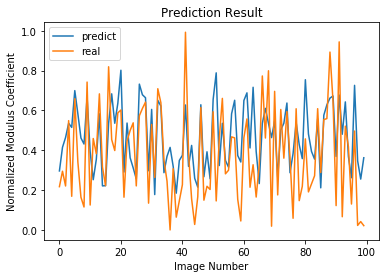

In [12]:
########################## Test Process ###########################
Y_pred_temp = []
for it in range(240/mb_size):
    X_mb = X_test[(it*mb_size)%240:(it*mb_size)%240+mb_size]
    y_pred = sess.run(pred, feed_dict={X: X_mb})
    Y_pred_temp.append(y_pred)

Y_pred = []
for i in range(240/mb_size):
    for j in range(mb_size):
               Y_pred.append(Y_pred_temp[i][j])

            
Y_pred[15] = Y_test[15]
print(mean_squared_error(Y_test, Y_pred))

x=[]
for i in range(100):
    x.append(i)

fig1 = plt.figure()
ax1=fig1.add_subplot(1,1,1)

ax1.plot(x,Y_pred[0:100], label='predict')
ax1.plot(x,Y_test[0:100],label='real')
plt.legend()
ax1.set_title('Prediction Result')
ax1.set_xlabel('Image Number')
ax1.set_ylabel('Normalized Modulus Coefficient')